In [4]:
# load libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os

# see process_data.py
import process_data as data

In [6]:
# load all csvs 
er_data_path = os.path.join("..", "data", "emergency_department_characteristics")
er_data = glob.glob(os.path.join(er_data_path, "*.csv")) 
print(len(er_data)) # 2005 - 2020 data

16


    ZIPCODE                                           geometry
0     90001  POLYGON ((-118.24338 33.98924, -118.24333 33.9...
1     90002  POLYGON ((-118.23431 33.96101, -118.23425 33.9...
2     90003  POLYGON ((-118.28285 33.97597, -118.28285 33.9...
3     90004  POLYGON ((-118.28410 34.08349, -118.28425 34.0...
4     90005  MULTIPOLYGON (((-118.33541 34.06179, -118.3350...
..      ...                                                ...
252   91790  POLYGON ((-117.94085 34.09248, -117.93997 34.0...
253   91791  POLYGON ((-117.91660 34.08645, -117.91660 34.0...
254   91792  POLYGON ((-117.89061 34.00858, -117.89061 34.0...
255   91801  POLYGON ((-118.13472 34.08512, -118.13472 34.0...
256   91803  POLYGON ((-118.15469 34.09042, -118.15469 34.0...

[257 rows x 2 columns]


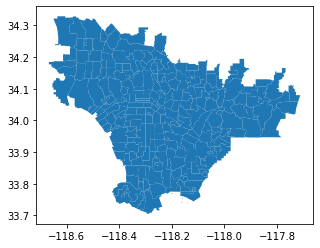

In [19]:
# load zipcode data 
zipcodes_shp = os.path.join("..", "processed", "collapsed_measures", "zipcodes_processed.shp") 
zipcodes = gpd.read_file(zipcodes_shp) 
print(zipcodes)

zipcodes.plot()
plt.show()

In [140]:
# create dict (to be converted to df) to store final data 
processed_data = dict() 

In [29]:
# open up a csv file, extract zipcodes 
ex_csv = er_data[0]
ex_df = pd.read_csv(ex_csv)

# get rows of relevant zipcodes
pattern = '|'.join(zipcodes["ZIPCODE"]) # regex of all zipcode ids; | = or
select_zipcodes = ex_df[ex_df["FAC_ZIPCODE"].str.contains(pattern)]
print(select_zipcodes[["FAC_ZIPCODE", "COUNTY"]]) # only 72 zipcodes

# check how much data there is for la county 
la_county = ex_df[ex_df["COUNTY"] == "Los Angeles"]
print(la_county[["FAC_ZIPCODE", "COUNTY"]]) # only 81

# confirm that all files have the same zipcodes 
for csv in er_data: 
    df = pd.read_csv(ex_csv)
    zips = df["FAC_ZIPCODE"][df["FAC_ZIPCODE"].str.contains(pattern)]
    if (not zips.equals(select_zipcodes["FAC_ZIPCODE"])):
        raise Exception("Files have different zipcodes")
    

    FAC_ZIPCODE       COUNTY
67        91801  Los Angeles
71        90706  Los Angeles
72        90640  Los Angeles
74        90015  Los Angeles
75        90301  Los Angeles
..          ...          ...
143       90059  Los Angeles
145       91367  Los Angeles
146       91706  Los Angeles
147       90806  Los Angeles
181       90623       Orange

[72 rows x 2 columns]
    FAC_ZIPCODE       COUNTY
67        91801  Los Angeles
68        93534  Los Angeles
69        90704  Los Angeles
70        90801  Los Angeles
71        90706  Los Angeles
..          ...          ...
143       90059  Los Angeles
144       91342  Los Angeles
145       91367  Los Angeles
146       91706  Los Angeles
147       90806  Los Angeles

[81 rows x 2 columns]


In [171]:
# use selected zipcodes going forward 
# zipcodes_to_keep = list(select_zipcodes["FAC_ZIPCODE"])
# filtered_zipcodes = zipcodes[zipcodes["ZIPCODE"].isin(zipcodes_to_keep)]

filtered_zipcodes = select_zipcodes["FAC_ZIPCODE"]
print(len(filtered_zipcodes))
# processed_data["ZIPCODE"] = list(filtered_zipcodes["ZIPCODE"])
# processed_data["geometry"] = list(filtered_zipcodes["geometry"])

# print(pd.DataFrame(processed_data))
# filtered_zipcodes.plot()
# plt.show()

72
57
72


In [156]:
# split csvs into "types" based on principal diag groups 
# exclude births; categorization is inconsistent across years, and has minimal counts
diag_groups_names = [ 
    "PerinatalDisorders",
    "PregnancyBirthPuerperium",
    "CongenitalAnomalies",
    "BloodBloodformingOrgans",
    "Circulatory",
    "Digestive",
    "Endocrine",
    "Respiratory",
    "NervousSensory",
    "Musculoskeletal",
    "Neoplasms",
    "Genitourinary", 
    "Infections",
    "InjuriesPoisoning",
    "MentalIllness",
    "Skin",
    "Symptoms",
    "Other"
]

diag_groups_names_no_nervous = [ 
    "PerinatalDisorders",
    "PregnancyBirthPuerperium",
    "CongenitalAnomalies",
    "BloodBloodformingOrgans",
    "Circulatory",
    "Digestive",
    "Endocrine",
    "Respiratory",
    "Musculoskeletal",
    "Neoplasms",
    "Genitourinary", 
    "Infections",
    "InjuriesPoisoning",
    "MentalIllness",
    "Skin",
    "Symptoms",
    "Other"
]

diag_groups_2005_2014 = [
    "Dx_Perinatal_disorders", 
    "Dx_All_Pregnancies", 
    "Dx_Congenital_anomalies", 
    "Dx_Blood_Bloodforming_organs",
    "Dx_Circulatory", 
    "Dx_Digestive", 
    "Dx_Endocrine_Metabolism", 
    "Dx_Respiratory", 
    "Dx_Nervous_Sensory_Systems", 
    "Dx_Musculoskeletal",
    "Dx_Neoplasms", 
    "Dx_Genitourinary", 
    "Dx_Infections", 
    "Dx_Injuries_Drugs_Complications", 
    "Dx_Psychoses_Neuroses", 
    "Dx_Skin_disorders", 
    "Dx_Symptoms", 
    "Dx_Other_Reasons"
]

# no nervous + sensory; need to merge
diag_groups_2016_2018 = [
    "DX_Perinatal_Disorders",
    "DX_All_Pregnancies"	
    "DX_Birth_Defects",	
    "DX_Blood_Disorders",		
    "DX_Circulatory_System",	
    "DX_Digestive_System",
    "DX_Endocrine_Diseases",	
    "DX_Respiratory_System",
    "DX_Musculoskeletal_System",
    "DX_Cancer",
    "DX_Genitourinary_System",
    "DX_Infections",
    "DX_Injuries_Poisonings",
    "DX_Mental_Disorders",
    "DX_Skin_Disorders",
    "DX_Symptoms",
    "DX_Other_Reasons"
]	

diag_groups_2016_2018_merge = [
    "DX_Nervous_System", 
    "DX_Ear_Disorders", 
    "DX_Eye_Disorders"
]

# ignores dx_Unacceptable_principal_diagno; are from mismatches btwn icd9 and icd10
# no nervous + sensory; need to merge
diag_groups_2019_2020 = [
    "dx_Certain_Perinatal_Conditions",
    "dx_Pregnancy_Childbirth",
    "dx_Congenital",
    "dx_Diseases_of_the_Blood",
    "dx_Circulatory",		
    "dx_Digestive",
    "dx_Endocrine",
    "dx_Respiratory",
    "dx_Musculoskeletal",	
    "dx_Neoplasms",
    "dx_Genitourinary",
    "dx_Infectious",
    "dx_Injury_Poisoning",
    "dx_MentalHealth",
    "dx_Skin",
    "dx_Symptoms_Signs_NEC", 
    "dx_Factors_Influencing_Health_St" # same as "Other", according to codes
]

diag_groups_2019_2020_merge = [
    "dx_Nervous_System", 
    "dx_Ear", 
    "dx_Eye"
]

age_groups_cols = [
    "Age_Under_1",
    "Age_01_09",
    "Age_10_19",
    "Age_20_29",
    "Age_30_39",	
    "Age_40_49",
    "Age_50_59",
    "Age_60_69",
    "Age_70_79",	
    "Age_80_"	
]

age_groups_names = [
    "Age_Under_1",
    "Age_01_09",
    "Age_10_19",
    "Age_20_29",
    "Age_30_39",	
    "Age_40_49",
    "Age_50_59",
    "Age_60_69",
    "Age_70_79",	
    "Age_80_and_Over"	
]

# TODO include ed_visits lmao..and extract for age!! 

# dicts, consts
age_groups = dict(zip(age_groups_cols, age_groups_names))
ed_visits = dict(ED_Visit = "EDvisits")

extract_2005_2014 = dict(zip(diag_groups_2005_2014, diag_groups_names))
extract_2005_2014.update(age_groups)
extract_2005_2014.update(ed_visits)

extract_2016_2018 = dict(zip(diag_groups_2016_2018, diag_groups_names))
extract_2016_2018.update(age_groups)
extract_2016_2018.update(ed_visits)

extract_2019_2020 = dict(zip(diag_groups_2019_2020, diag_groups_names))
extract_2019_2020.update(age_groups)
extract_2019_2020.update(ed_visits)

merge_2005_2014 = None
merge_2016_2018 = dict(NervousSensory = diag_groups_2016_2018_merge)
merge_2019_2020 = dict(NervousSensory = diag_groups_2019_2020_merge)

paths_2005_2014 = dict(zip(range(2005, 2015), er_data[0:11]))
paths_2016_2018 = dict(zip(range(2016, 2019), er_data[11:14]))
paths_2019_2020 = dict(zip(range(2019, 2021), er_data[14:16]))

# 2015: doesn't have prinicpal diag groups, bc of switch from icd9 to icd10 codes; 
# will just extract ed visits and age groups 

In [262]:
# iterate through each path group, and do data extract stuff! rahhhhh
for year in paths_2005_2014:
    print(f"getting data for {year}")
    temp_dict = dict()
    extract_dict = dict()

    # create Data object 
    data_obj = data.Data(
        path=paths_2005_2014[year], 
        cols_to_extract=extract_2005_2014, # merge with ed visit and age group
        cols_to_merge=merge_2005_2014
    )
    df = data_obj.data_read_csv()
    
    # get rows of relevant zipcodes
    pattern = '|'.join(filtered_zipcodes) # regex of all zipcode ids; | = or
    formatted = df.filter(regex="FAC_ZIPCODE|DBA_ZIP_CODE").squeeze().astype("string").str[0:5] # some csvs have zipcodes as floats; remove decimals
    filtered = df[formatted.str.contains(pattern, na=False)] # if value is nan, replace w false
    if (len(filtered) != 72):
        raise Exception(f"Expected num zipcodes: 72, actual num zipcodes: {len(filtered)}")
    
    # extract
    extracted_cols = data_obj.data_extract_cols(filtered)
    if (not extracted_cols.empty):
        extracted_dict = extracted_cols.to_dict(orient="list")
        temp_dict.update(extracted_dict)
    
    # merge and extract 
    merged_cols = data_obj.data_merge_cols(filtered)
    if (not merged_cols.empty):
        merged_dict = merged_cols.to_dict(orient="list")
        temp_dict.update(merged_dict)

    # add cols for year and zipcode and geos
    # TODO, whene xtracting, try sorting to ensure that everything lines up 
    filtered_zips =  filtered.filter(regex="FAC_ZIPCODE|DBA_ZIP_CODE").squeeze()
    temp_dict["ZIPCODE"] = filtered_zips.tolist()
    temp_dict["YEAR"] = [year] * len(temp_dict["ZIPCODE"])

    geos = zipcodes[zipcodes["ZIPCODE"].isin(filtered_zips.tolist())]["geometry"]
    temp_dict["geometry"] = geos.tolist()
    # zipcodes_to_keep = list(select_zipcodes["FAC_ZIPCODE"])
    # filtered_zipcodes = zipcodes[zipcodes["ZIPCODE"].isin(zipcodes_to_keep)]

    # add rows for missing zipcodes (with na values) 
    missing_zipcodes = zipcodes[~zipcodes["ZIPCODE"].index.isin(filtered_zips.index)]
    if (len(missing_zipcodes) != 185):
        raise Exception("incorrect num zipcodes! eeeek")

    missing_data = []
    len_nas = len(temp_dict) - 1
    for i in len(missing_zipcodes):
        zip = missing_zipcodes.loc[i, "ZIPCODE"]
        geo = missing_zipcodes.loc[i, "geometry"]
        missing_data.append([year, zip] + [pd.NA] * len_nas + [geo])
    
    # add to dict....by converting to df 
    temp_df = pd.DataFrame(temp_dict)

    # move year and zip to front
    temp_df.insert(0, "YEAR", df.pop("YEAR"))
    df.insert(1, "ZIPCODE", df.pop("ZIPCODE"))

    temp_df._append(missing_data)

    # sort based on zipcodes (covert to num) 
    temp_df["ZIPCODE"] = temp_df["ZIPCODE"].astype("int32", errors="ignore")
    temp_df.sort_values(by="ZIPCODE", inplace=True)

    # append to processed_data 
    if (processed_data.empty): # if empty
        processed_data = temp_df
    else:
        processed_data._append(temp_df)

    # todo include check, to make sure that number of extract zipcodes is 72...


getting data for 2005


Exception: Expected num zipcodes: 72, actual num zipcodes: 70

In [257]:
# filtered_zips =  filtered.filter(regex="FAC_ZIPCODE|DBA_ZIP_CODE")
processed_data_copy = processed_data
processed_df = pd.DataFrame(processed_data_copy)
processed_df.insert(0, "YEAR", processed_df.pop("YEAR"))
processed_df.insert(1, "ZIPCODE", processed_df.pop("ZIPCODE"))
processed_df = processed_df[processed_df.YEAR == 2005]

# clean zipcdoe data: (probably do this in the r file...) 
processed_df["ZIPCODE"] = processed_df["ZIPCODE"].str.split('-').str[0]

# get missing zipcodes 
missing_zips = zipcodes[~zipcodes["ZIPCODE"].index.isin(filtered_zipcodes.index)]
# df[~df.index.isin(df_a.index+df_b.index)]

# create list with year, zipcode, and a bunch of nas 
year = 2005
missing_data = []
len_nas = len(processed_df.columns) - 2
for zip in missing_zips[["ZIPCODE", "geometry"]]: 
    print(zip)
    # print(geo)

print(processed_df)
print(missing_data)

ZIPCODE
geometry
    YEAR ZIPCODE  PerinatalDisorders  PregnancyBirthPuerperium  \
0   2005   91801                 1.0                      61.0   
1   2005   90706                16.0                     527.0   
2   2005   90640                26.0                     808.0   
3   2005   90015                47.0                    1628.0   
4   2005   90301                30.0                    1051.0   
..   ...     ...                 ...                       ...   
65  2005   90059                18.0                     587.0   
66  2005   91367                 4.0                     236.0   
67  2005   91706                31.0                     807.0   
68  2005   90806                 NaN                       NaN   
69  2005   90623                15.0                     278.0   

    CongenitalAnomalies  BloodBloodformingOrgans  Circulatory  Digestive  \
0                   1.0                     14.0        184.0      695.0   
1                  10.0               

In [261]:
print(processed_df.loc[0, "ZIPCODE"])

91801


In [247]:
processed_df = processed_df._append(missing_data)
processed_df

,YEAR,ZIPCODE,PerinatalDisorders,PregnancyBirthPuerperium,CongenitalAnomalies,BloodBloodformingOrgans,Circulatory,Digestive,Endocrine,Respiratory,...,10,11,12,13,14,15,16,17,18,19
0,2005.0,91801,1.0,61.0,1.0,14.0,184.0,695.0,128.0,1003.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005.0,90706,16.0,527.0,10.0,18.0,135.0,375.0,90.0,642.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005.0,90640,26.0,808.0,1.0,49.0,349.0,623.0,253.0,2488.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005.0,90015,47.0,1628.0,9.0,102.0,523.0,1670.0,521.0,3608.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005.0,90301,30.0,1051.0,16.0,156.0,1061.0,1823.0,656.0,4101.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [255]:
# processed_df["ZIPCODE"] = processed_df["ZIPCODE"].astype("float", errors="ignore")
# print(processed_df["ZIPCODE"].dtype)

processed_df["ZIPCODE"] = processed_df["ZIPCODE"].astype("int32", errors="ignore")
sorted = processed_df.sort_values(by="ZIPCODE")
sorted

,YEAR,ZIPCODE,PerinatalDisorders,PregnancyBirthPuerperium,CongenitalAnomalies,BloodBloodformingOrgans,Circulatory,Digestive,Endocrine,Respiratory,...,10,11,12,13,14,15,16,17,18,19
43,2005.0,90007,4.0,NaN,16.0,3.0,9.0,13.0,1.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005.0,90015,47.0,1628.0,9.0,102.0,523.0,1670.0,521.0,3608.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2005.0,90017,47.0,937.0,15.0,69.0,696.0,1772.0,450.0,2098.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,2005.0,90019,2.0,95.0,2.0,40.0,372.0,495.0,212.0,983.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2005.0,90023,14.0,265.0,2.0,8.0,60.0,656.0,45.0,1037.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [251]:
test_zips = processed_df
test_zips["ZIPCODE"] = test_zips["ZIPCODE"].astype("int32", errors="ignore")
test_zips.sort_values(by="ZIPCODE", inplace=True)
test_zips

,YEAR,ZIPCODE,PerinatalDisorders,PregnancyBirthPuerperium,CongenitalAnomalies,BloodBloodformingOrgans,Circulatory,Digestive,Endocrine,Respiratory,...,10,11,12,13,14,15,16,17,18,19
43,2005.0,90007,4.0,NaN,16.0,3.0,9.0,13.0,1.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005.0,90015,47.0,1628.0,9.0,102.0,523.0,1670.0,521.0,3608.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2005.0,90017,47.0,937.0,15.0,69.0,696.0,1772.0,450.0,2098.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,2005.0,90019,2.0,95.0,2.0,40.0,372.0,495.0,212.0,983.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2005.0,90023,14.0,265.0,2.0,8.0,60.0,656.0,45.0,1037.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [238]:
test_df = pd.DataFrame(dict(
    hi = [1, 2, 3],
    hello =[ 5, 109, 9]
))

test_df.sort_values(by=["hello"], ascending=True, inplace=True)
test_df

,hi,hello
0,1,5
2,3,9
1,2,109


In [183]:
test = [2005, 900001] + [pd.NA] * 3
print(test)

[2005, 900001, <NA>, <NA>, <NA>]


In [155]:
df = pd.DataFrame(processed_data)
# move year and zipcode to front 
# insert column with insert(location, column_name, column_value)

df.insert(0, "YEAR", df.pop("YEAR"))
df.insert(1, "ZIPCODE", df.pop("ZIPCODE"))
df.head

<bound method NDFrame.head of      YEAR ZIPCODE  PerinatalDisorders  PregnancyBirthPuerperium  \
0    2005   91801                 1.0                      61.0   
1    2005   90706                16.0                     527.0   
2    2005   90640                26.0                     808.0   
3    2005   90015                47.0                    1628.0   
4    2005   90301                30.0                    1051.0   
..    ...     ...                 ...                       ...   
629  2014   90502                46.0                     861.0   
630  2014   90804                 3.0                     324.0   
631  2014   90806               331.0                    2716.0   
632  2014   90806                 5.0                     293.0   
633  2014   90732                22.0                    1018.0   

     CongenitalAnomalies  BloodBloodformingOrgans  Circulatory  Digestive  \
0                    1.0                     14.0        184.0      695.0   
1          

In [142]:
print(processed_data)

{'PerinatalDisorders': None, 'PregnancyBirthPuerperium': None, 'CongenitalAnomalies': None, 'BloodBloodformingOrgans': None, 'Circulatory': None, 'Digestive': None, 'Endocrine': None, 'Respiratory': None, 'NervousSensory': None, 'Musculoskeletal': None, 'Neoplasms': None, 'Genitourinary': None, 'Infections': None, 'InjuriesPoisoning': None, 'MentalIllness': None, 'Skin': None, 'Symptoms': None, 'Other': None, 'ZIPCODE': None, 'YEAR': None}


In [138]:
print(temp_dict.keys())
print(processed_data.keys())
# for key in temp_dict.keys():
    # print(key)
    # processed_data[key] = processed_data[key].extend(temp_dict[key])
    # print(processed_data[key])
    # print(temp_dict[key])

print(pd.DataFrame(processed_data))

dict_keys(['PerinatalDisorders', 'PregnancyBirthPuerperium', 'CongenitalAnomalies', 'BloodBloodformingOrgans', 'Circulatory', 'Digestive', 'Endocrine', 'Respiratory', 'NervousSensory', 'Musculoskeletal', 'Neoplasms', 'Genitourinary', 'Infections', 'InjuriesPoisoning', 'MentalIllness', 'Skin', 'Symptoms', 'Other', 'ZIPCODE', 'YEAR'])
dict_keys(['PerinatalDisorders', 'PregnancyBirthPuerperium', 'CongenitalAnomalies', 'BloodBloodformingOrgans', 'Circulatory', 'Digestive', 'Endocrine', 'Respiratory', 'NervousSensory', 'Musculoskeletal', 'Neoplasms', 'Genitourinary', 'Infections', 'InjuriesPoisoning', 'MentalIllness', 'Skin', 'Symptoms', 'Other', 'ZIPCODE', 'YEAR'])


ValueError: If using all scalar values, you must pass an index

In [101]:
# test with 2011, 2012; data is weird there??? 

path_2012 = er_data[7]
df_2012 = pd.read_csv(path_2012)

pattern = '|'.join(filtered_zipcodes["ZIPCODE"]) # regex of all zipcode ids; | = or
print(pattern)

series = df_2012.filter(regex="FAC_ZIPCODE|DBA_ZIP_CODE").squeeze()
print(type(series))

90007|90015|90017|90019|90023|90027|90033|90034|90048|90057|90059|90095|90241|90247|90255|90262|90291|90301|90404|90502|90503|90602|90605|90623|90640|90650|90706|90710|90712|90716|90723|90732|90804|90806|91007|91105|91204|91206|91208|91345|91352|91356|91367|91402|91403|91405|91436|91706|91723|91733|91740|91754|91767|91773|91776|91790|91801
<class 'pandas.core.series.Series'>


In [49]:
# test dict appending 
dict1 = dict(
    hi = [1, 2], 
    hello = [3, 4]
)

dict2 = dict(
    hi = [3], 
    hello = [5]
)

if ("hi" in dict1):
    print("oaijf")
# iterate through dict1, append dict2 stuff 
for key in dict1:
    dict1[key] = dict1[key] + dict2[key]
print(dict1)


oaijf
{'hi': [1, 2, 3], 'hello': [3, 4, 5]}


In [ ]:
# iterate through each path group, and do data extract stuff! rahhhhh
for path in paths_2005_2015:
    # create Data object 
    data_obj = data.Data(
        path=path, 
        cols_to_extract=extract_2005_2015, 
        cols_to_merge=merge_2005_2015
    )
    df = data_obj.data_read_csv()
    
    # get rows of relevant zipcodes
    pattern = '|'.join(filtered_zipcodes["ZIPCODE"]) # regex of all zipcode ids; | = or
    filtered = df[df["FAC_ZIPCODE"].str.contains(pattern)]

    # extract
    extracted_cols = data_obj.data_extract_cols(filtered)
    if (not processed_data): # if empty 
        processed_data.update(extracted_cols.to_dict(orient="list"))
    else:
        # concatenate, based on keys 
        processed_data.append()



    # add to dict! 


In [ ]:
# standrdize verything using acs population data...

In [ ]:
# convert compiled data into df 

# add rows for missing zipcodes, where their data is na

In [ ]:
# plot stuff hrmm